In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-recommendation-database-2020/watching_status.csv
/kaggle/input/anime-recommendation-database-2020/rating_complete.csv
/kaggle/input/anime-recommendation-database-2020/animelist.csv
/kaggle/input/anime-recommendation-database-2020/anime.csv
/kaggle/input/anime-recommendation-database-2020/anime_with_synopsis.csv
/kaggle/input/anime-recommendation-database-2020/html folder/instructions.txt
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_1.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/staff.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_2.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/pictures.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/stats.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/details.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_3.html
/kaggle/input/anime

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

In [4]:
rating = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')
anime_df = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')
anime_with_synopsis = pd.read_csv('../input/anime-recommendation-database-2020/anime_with_synopsis.csv')
anime_with_synopsis.drop(['MAL_ID', 'Score', 'Genders'], axis=1, inplace=True)
anime_with_synopsis = anime_with_synopsis.rename(columns={"Name": "name"})
# anime_with_synopsis.head(5)

print('rating shape:', rating.shape)
print('anime_df shape:', anime_df.shape)

rating shape: (7813737, 3)
anime_df shape: (12294, 7)


In [5]:
anime_df = anime_df.merge(anime_with_synopsis, on=["name"])
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,sypnopsis
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262,"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have conquered Japan, they try to thrive on doing whatever work they can get their hands on. However, Shinpachi and Kagura still haven't been paid... Does Gin-chan really spend all that cash playing pachinko? Meanwhile, when Gintoki drunkenly staggers home one night, an alien spaceship crashes nearby. A fatally injured crew member emerges from the ship and gives Gintoki a strange, clock-shaped device, warning him that it is incredibly powerful and must be safeguarded. Mistaking it for his alarm clock, Gintoki proceeds to smash the device the next morning and suddenly discovers that the world outside his apartment has come to a standstill. With Kagura and Shinpachi at his side, he sets off to get the device fixed; though, as usual, nothing is ever that simple for the Yorozuya team. Filled with tongue-in-cheek humor and moments of heartfelt emotion, Gintama 's fourth season finds Gintoki and his friends facing both their most hilarious misadventures and most dangerous crises yet."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fello

 ##### 1) anime_data:
* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".


##### 2) rating_data:
* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

# Удаляем null
### Во-первых, нам проще создать систему рекомендаций, если набор данных не имеет значений NULL. Итак, мы удалим значения NULL

In [6]:
null_features = anime_df.columns[anime_df.isna().any()]
anime_df[null_features].isna().sum()

genre     52 
type      15 
rating    150
dtype: int64

In [7]:
anime_df.dropna(inplace=True)

###  Возможно, в названии аниме используется японские буквы или специальные символы, решаем эту пробелему:


In [8]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)

# EDA (Exploratory data analysis)

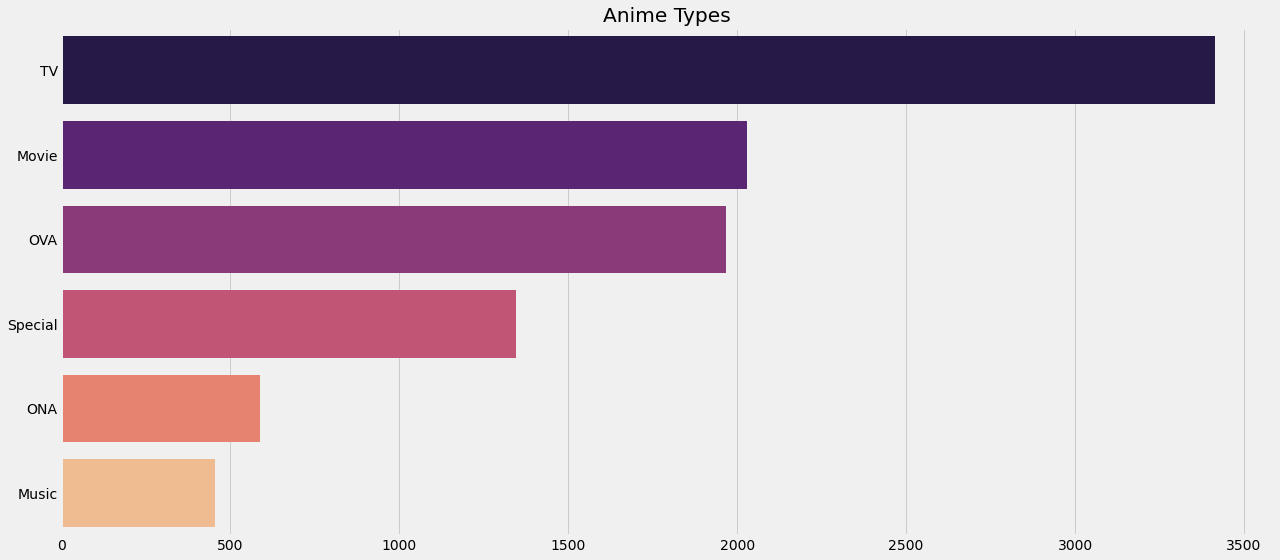

In [9]:
type_count = anime_df['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='magma').set_title('Anime Types')

plt.tight_layout()
plt.show()



In [10]:
import plotly.graph_objects as go
labels = anime_df['type'].value_counts().index
values = anime_df['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Medium of Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

## Какие жанры есть в наборе данных аниме?

In [11]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime_df['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

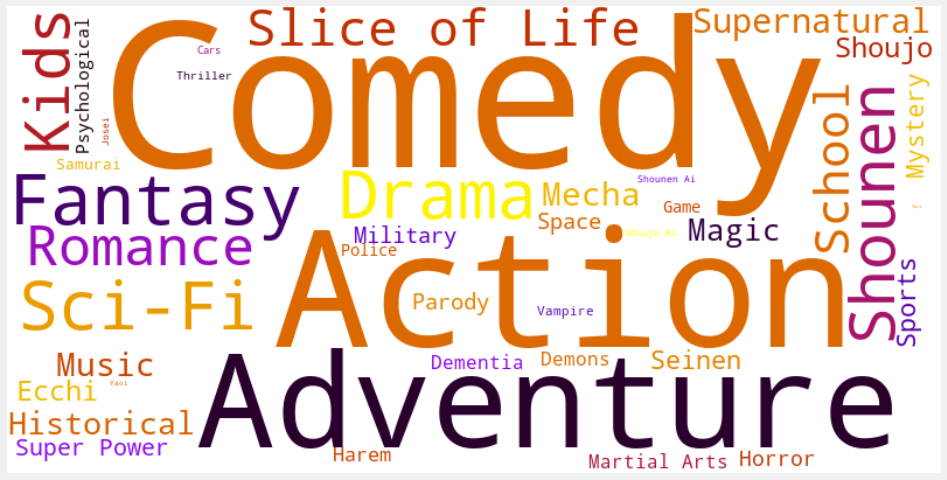

In [12]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
anime_df[anime_df['episodes'] == 'Unknown']['name'][:5] # те аниме, к-во эпизодов/серий, к-х неизвестно (видимо их очень много)

63     One Piece                             
225    Detective Conan                       
553    Naruto: Shippuuden                    
877    Crayon Shin-chan                      
902    Tanaka-kun wa Itsumo Kedaruge Specials
Name: name, dtype: object

In [14]:
# тут вот можем посмотреть на то, какие аниме к-вом серий больше чем 1500
episodes_count = anime_df[anime_df['episodes'] != 'Unknown'][['name', 'episodes']]
episodes_count['episodes'] = pd.to_numeric(episodes_count['episodes'])

episodes_count.query('episodes>1500')

,name,episodes
823,Doraemon (1979),1787
5545,Oyako Club,1818
8303,Kirin Monoshiri Yakata,1565


# У какого аниме самый высокий рейтинг?
### Сюда я включила аниме, у которых более 500000 community members
### Топ-5 

In [15]:
anime_df[['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>500000')[:5]

,name,rating,members,type
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
3,Steins;Gate,9.17,673572,TV
9,Code Geass: Hangyaku no Lelouch R2,8.98,572888,TV
15,Code Geass: Hangyaku no Lelouch,8.83,715151,TV
19,One Punch Man,8.82,552458,TV


# Выведем еще рейтинг для полнометражных фильмов

In [16]:
anime_df[anime_df['type'] == 'Movie'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>200000')[:5]

,name,rating,members,type
0,Kimi no Na wa.,9.37,200630,Movie
11,Sen to Chihiro no Kamikakushi,8.93,466254,Movie
14,Ookami Kodomo no Ame to Yuki,8.84,226193,Movie
20,Mononoke Hime,8.81,339556,Movie
21,Suzumiya Haruhi no Shoushitsu,8.81,240297,Movie


# И выведем рейтинг для OVA (Original Animated Video)
#### OVA - это японские анимационные фильмы и сериалы, созданные специально для выпуска в домашних видеоформатах без предварительного показа на телевидении или в кинотеатрах.

In [17]:
anime_df[anime_df['type'] == 'OVA'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>100000')[:5]

,name,rating,members,type
17,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,8.83,129307,OVA
55,Hellsing Ultimate,8.59,297454,OVA
218,Detroit Metal City,8.26,104893,OVA
402,FLCL,8.06,305165,OVA
414,Golden Boy,8.05,113040,OVA


# 1 ЧАСТЬ Content-Based Recommendation-System

#### Content-Based Recommender полагается на схожесть рекомендуемых элементов. Основная идея заключается в том, что если вам понравился предмет, то вам понравится и «похожий» предмет. 

#### Контентный метод также решает проблему холодного старта. Если пользователь впервые посещает платформу, мы еще ничего о нем не знаем. Как дать  отличные рекомендации? 
* Во-первых, порекомендовать самые популярные фильмы. 
* После того, как пользователь посмотрит/нажмет на какой-либо продукт, мы выбирем фильмы с похожим содержанием, чтобы порекомендовать. 

TF - отношение числа вхождений некоторого слова к общему числу слов документа.(просто частота слова в документе.) 
IDF - энверсия частоты, с которой некоторое слово встречается в документах коллекции.
Пример. Предположим, мы ищем в Google «the results of latest European Socccer games». Несомненно, что «the» будет встречаться чаще, чем «Socccer games», но относительная важность Socccer games выше, с точки зрения поискового запроса.

В таких случаях взвешивание TF-IDF сводит на нет влияние часто встречающихся слов при определении важности элемента (документа).

#####  Это даст вам матрицу, в которой каждый столбец представляет слово в обзорном словаре (все слова, которые встречаются хотя бы в одном документе), а каждая строка представляет фильм, как и раньше. Это сделано для уменьшения важности часто встречающихся слов. в обзорах сюжетов и, следовательно, их значимость для расчета окончательной оценки сходства.

# Сначала попробуем с помощью библиотеки дать реком. на основе жанров

In [18]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

genre_str = anime_df['genre'].str.split(',').astype(str)

tfidf_bibl = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf_bibl.fit_transform(genre_str)

tfidf_matrix.shape

# tfidf.get_feature_names()

CPU times: user 202 ms, sys: 4.82 ms, total: 207 ms
Wall time: 214 ms


(9800, 5140)

In [19]:

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_genre = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_genre[:4, :4]

array([[1.        , 0.01559281, 0.        , 0.        ],
       [0.01559281, 1.        , 0.01589466, 0.        ],
       [0.        , 0.01589466, 1.        , 0.0529717 ],
       [0.        , 0.        , 0.0529717 , 1.        ]])

#### Мы видим, что для описания жанров 9800 аниме в нашем наборе данных было использовано 5140 различных слов.
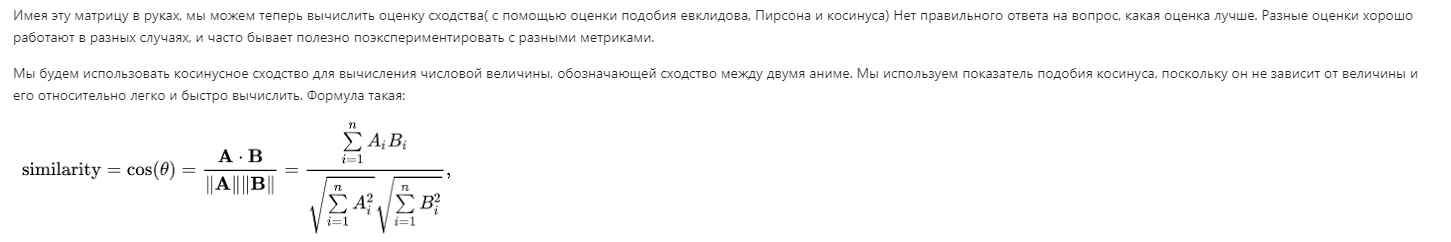

# Cosine-Similarity
Косинусное подобие берет угол между двумя ненулевыми векторами и вычисляет косинус этого угла, и это значение известно как сходство между двумя векторами.
Этот показатель сходства варьируется от 0 до 1, где 0 - самый низкий (наименее похожий), а 1 - самый высокий (самый похожий).
Если угол между двумя векторами равен 0 °, то сходство будет 1. И наоборот, если угол между двумя векторами равен 90 °, то сходство будет равно 0. Для двух векторов с углом больше 90 ° мы также считать их равными 0.

## Функция для вывода рекомендаций:

In [20]:
indices = pd.Series(anime_df.index, index=anime_df['name']) # для того, чтобы получить индекс аниме по его названию

def give_recommendations(title, cosine_sim):
    
            idx = indices[title] # получаем индекс фильма, соответствующий названию
            sim_scores = (enumerate(cosine_sim[idx])) # получаем оценки попарного сходства всех аниме с этим аниме
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # сортировка аниме по показателям схожести
            sim_scores = sim_scores[0:11] # выводим топ 10
        
        
            anime_indices = [i[0] for i in sim_scores] # получаем индексы этих аниме
            similarity_ = [i[1] for i in sim_scores] 
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values,
                                 'genre': anime_df['genre'].iloc[anime_indices].values})  # выводим название и жанр аниме
        

In [21]:
%%time
give_recommendations('Naruto: Shippuuden', cosine_sim_genre)

CPU times: user 15.2 ms, sys: 46 µs, total: 15.2 ms
Wall time: 14.8 ms


,Anime name,Similarity,Type,genre
0,Boruto: Naruto the Movie,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
1,Naruto: Shippuuden,1.000000,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
2,Naruto,1.000000,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
3,Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi,1.000000,Special,"Action, Comedy, Martial Arts, Shounen, Super Power"
4,Naruto x UT,1.000000,OVA,"Action, Comedy, Martial Arts, Shounen, Super Power"
5,Naruto: Shippuuden Movie 4 - The Lost Tower,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
6,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
7,Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
8,Battle Spirits: Ryuuko no Ken,0.789114,OVA,"Action, Comedy, Martial Arts, Shounen"
9,Kyutai Panic Adventure!,0.670396,Special,"Action, Martial Arts, Shounen, Super Power"


# Попробуем сделать рекомендации на основании описания 

# Библиотечная функция

In [22]:
%%time
# genres_str1 = anime_df['sypnopsis'].str.split(',').astype(str)
sypnopsis_str1 = anime_df['sypnopsis'].str.split(',').astype(str)
# sypnopsis_str = anime_df['sypnopsis'].str.split(',').astype(str)
# unit =  pd.concat([sypnopsis_str1, genres_str1])

tfidf_sypnopsis = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix_sypnopsis = tfidf_sypnopsis.fit_transform(sypnopsis_str1)

tfidf_matrix_sypnopsis.shape

# # tfidf.get_feature_names()

CPU times: user 11.6 s, sys: 455 ms, total: 12.1 s
Wall time: 12.1 s


(9800, 1445801)

In [23]:
cosine_sim_synops_bibl = cosine_similarity(tfidf_matrix_sypnopsis, tfidf_matrix_sypnopsis)
cosine_sim_synops_bibl[:4, :4]

array([[1.        , 0.01132345, 0.0129385 , 0.01587901],
       [0.01132345, 1.        , 0.01598376, 0.01328853],
       [0.0129385 , 0.01598376, 1.        , 0.01371742],
       [0.01587901, 0.01328853, 0.01371742, 1.        ]])

In [24]:
%%time
give_recommendations('Naruto: Shippuuden', cosine_sim_synops_bibl)

CPU times: user 18.4 ms, sys: 3.24 ms, total: 21.7 ms
Wall time: 20.8 ms


,Anime name,Similarity,Type,genre
0,Naruto: Shippuuden,1.000000,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
1,Naruto,0.078965,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
2,Naruto: Shippuuden Movie 6 - Road to Ninja,0.053816,Movie,"Action, Adventure, Martial Arts, Shounen, Super Power"
3,Haou Daikei Ryuu Knight: Adeu Legend II,0.049187,OVA,"Action, Adventure, Fantasy, Mecha"
4,Naruto SD: Rock Lee no Seishun Full-Power Ninden,0.046993,TV,"Action, Comedy, Parody"
5,Boruto: Naruto the Movie,0.043852,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
6,Naruto: Akaki Yotsuba no Clover wo Sagase,0.042333,Special,"Adventure, Comedy, Shounen"
7,Jigoku Sensei Nube OVA,0.040856,OVA,"Action, Comedy, Demons, Horror, School, Shounen, Supernatural"
8,The Last: Naruto the Movie,0.040768,Movie,"Action, Martial Arts, Romance, Shounen, Super Power"
9,Naruto: Shippuuden Movie 4 - The Lost Tower,0.040567,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"


# Теперь моя реализация для рекомендаций на основе жанров

In [25]:
my_anime_df = pd.DataFrame()

In [26]:
    my_anime_df['sypnopsis'] = anime_df['sypnopsis'].map(lambda x: x.lower().split(' '))
    my_anime_df['genre'] = anime_df['genre'].map(lambda x: x.lower().split(' '))


In [27]:
#     anime_df['sypnopsis'] = anime_df['sypnopsis'].map(lambda x: x.lower().split(' '))
#     anime_df['genre'] = anime_df['genre'].map(lambda x: x.lower().split(' '))

In [28]:
# anime_df.head(10)
my_anime_df

,sypnopsis,genre
0,"[suha, miyamizu,, a, high, school, girl,, yearns, to, live, the, life, of, a, boy, in, the, bustling, city, of, tokyo—a, dream, that, stands, in, stark, contrast, to, her, present, life, in, the, countryside., meanwhile, in, the, city,, taki, tachibana, lives, a, busy, life, as, a, high, school, student, while, juggling, his, part-time, job, and, hopes, for, a, future, in, architecture., one, day,, mitsuha, awakens, in, a, room, that, is, not, her, own, and, suddenly, finds, herself, living, the, dream, life, in, tokyo—but, in, taki's, body!, elsewhere,, taki, finds, himself, living, mitsuha's, life, in, the, humble, countryside., in, pursuit, of, an, ...]","[drama,, romance,, school,, supernatural]"
1,"[""in, order, for, something, to, be, obtained,, something, of, equal, value, must, be, lost."", alchemy, is, bound, by, this, law, of, equivalent, exchange—something, the, young, brothers, edward, and, alphonse, elric, only, realize, after, attempting, human, transmutation:, the, one, forbidden, act, of, alchemy., they, pay, a, terrible, price, for, their, transgression—edward, loses, his, left, leg,, alphonse, his, physical, body., it, is, only, by, the, desperate, sacrifice, of, edward's, right, arm, that, he, is, able, to, affix, alphonse's, soul, to, a, suit, of, armor., devastated, and, alone,, it, is, the, hope, that, they, would, both, eventually, return, to, their, original, bodies, that, ...]","[action,, adventure,, drama,, fantasy,, magic,, military,, shounen]"
2,"[gintoki,, shinpachi,, and, kagura, return, as, the, fun-loving, but, broke, members, of, the, yorozuya, team!, living, in, an, alternate-reality, edo,, where, swords, are, prohibited, and, alien, overlords, have, conquered, japan,, they, try, to, thrive, on, doing, whatever, work, they, can, get, their, hands, on., however,, shinpachi, and, kagura, still, haven't, been, paid..., does, gin-chan, really, spend, all, that, cash, playing, pachinko?, meanwhile,, when, gintoki, drunkenly, staggers, home, one, night,, an, alien, spaceship, crashes, nearby., a, fatally, injured, crew, member, emerges, from, the, ship, and, gives, gintoki, a, strange,, clock-shaped, device,, warning, him, that, it, is, incredibly, powerful, and, must, be, ...]","[action,, comedy,, historical,, parody,, samurai,, sci-fi,, shounen]"
3,"[the, self-proclaimed, mad, scientist, rintarou, okabe, rents, out, a, room, in, a, rickety, old, building, in, akihabara,, where, he, indulges, himself, in, his, hobby, of, inventing, prospective, ""future, gadgets"", with, fellow, lab, members:, mayuri, shiina,, his, air-headed, childhood, friend,, and, hashida, itaru,, a, perverted, hacker, nicknamed, ""daru."", the, three, pass, the, time, by, tinkering, with, their, most, promising, contraption, yet,, a, machine, dubbed, the, ""phone, microwave,"", which, performs, the, strange, function, of, morphing, bananas, into, piles, of, green, gel., though, miraculous, in, itself,, the, phenomenon, doesn't, provide, anything, concrete, in, okabe's, search, for, a, scientific, breakthrough;, that, is,, until, the, ...]","[sci-fi,, thriller]"
4,"[hunter, x, hunter, is, set, in, a, world, where, hunters, exist, to, perform, all, manner, of, dangerous, tasks, like, capturing, criminals, and, bravely, searching, for, lost, treasures, in, uncharted, territories., twelve-year-old, gon, freecss, is, determined, to, become, the, best, hunter, possible, in, hopes, of, finding, his, father,, who, was, a, hunter, himself, and, had, long, ago, abandoned, his, young, son., however,, gon, soon, realizes, the, path, to, achieving, his, goals, is, far, more, challenging, than, he, could, have, ever, imagined., along, the, way, to, becoming, an, official, hunter,, gon, befriends, the, lively, doctor-in-training, leorio,, vengeful, kurapika,, and, rebellious, ex-assassin, killua., ...]","[action,, adventure,, shounen,, super, power]"
...,...,...
9988,"[this, ova, features, five, of, the, most, popular, gi

In [29]:
def data_preproc(descr):
    descr = descr.replace('\n', '')
    descr = ' '.join(re.sub('https?://\S+|www\.\S+','',descr).split())
    descr = re.sub("[!@#$+%*:()/<.=,—']", '', descr)
#     text = ' '.join([word for word in text.split() if word not in stop])
#     text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return descr

In [30]:
# anime_df['sypnopsis'] = anime_df['sypnopsis'].apply(lambda x: data_preproc(x))
# anime_df['genre'] = anime_df['genre'].apply(lambda x: data_preproc(x))
# anime_df.head(2)
my_anime_df['sypnopsis'] = anime_df['sypnopsis'].apply(lambda x: data_preproc(x))
my_anime_df['genre'] = anime_df['genre'].apply(lambda x: data_preproc(x))
my_anime_df.head(2)

,sypnopsis,genre
0,suha Miyamizu a high school girl yearns to live the life of a boy in the bustling city of Tokyoa dream that stands in stark contrast to her present life in the countryside Meanwhile in the city Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture One day Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyobut in Takis body Elsewhere Taki finds himself living Mitsuhas life in the humble countryside In pursuit of an answer to this strange phenomenon they begin to search for one another Kimi no Na wa revolves around Mitsuha and Takis actions which begin to have a dramatic impact on each others lives weaving them into a fabric held together by fate and circumstance,Drama Romance School Supernatural
1,"""In order for something to be obtained something of equal value must be lost"" Alchemy is bound by this Law of Equivalent Exchangesomething the young brothers Edward and Alphonse Elric only realize after attempting human transmutation the one forbidden act of alchemy They pay a terrible price for their transgressionEdward loses his left leg Alphonse his physical body It is only by the desperate sacrifice of Edwards right arm that he is able to affix Alphonses soul to a suit of armor Devastated and alone it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist the Fullmetal Alchemist Three years of searching later the brothers seek the Philosophers Stone a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange Even with military allies Colonel Roy Mustang Lieutenant Riza Hawkeye and Lieutenant Colonel Maes Hughes on their side the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosophers Stone but their countrys murky history as well In between finding a serial killer and racing against time Edward and Alphonse must ask themselves if what they are doing will make them human again or take away their humanity",Action Adventure Drama Fantasy Magic Military Shounen


In [31]:
all_unique = set()
for i in range(0,len(my_anime_df['genre'])-1):
    unique_words = set(my_anime_df['genre'].values[i]).union(set(my_anime_df['genre'].values[i+1]))
    all_unique.update(unique_words)



In [32]:
    #мои функции
    def myTF(wordDict, val):
        tfDict = {}
        valCount = len(val)
        for word, count in wordDict.items():
            tfDict[word] = count / float(valCount)
        return tfDict

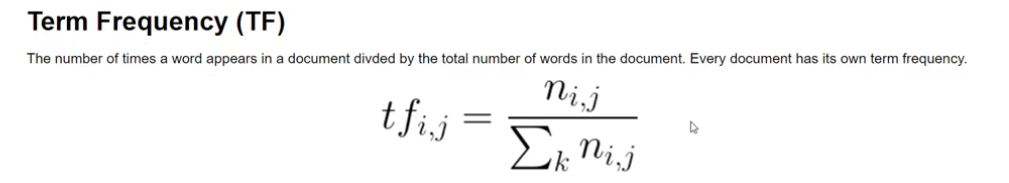

In [33]:
def myIDF(genre):  
    import math  
    N = len(genre) 
#     print(N)
      
    idfDict = dict.fromkeys(genre[0].keys(), 0)  
    for genr in genre:  
        for word, val in genr.items():  
            if val > 0:  
                idfDict[word] += 1  
      
    for word, val in idfDict.items():  
        idfDict[word] = math.log(N / float(val))  
    return idfDict

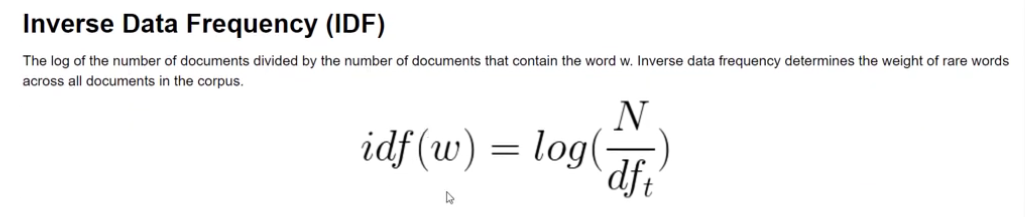

In [34]:
def myTFIDF(tfValues, idfs): 
    tfidf = {} 
    for word, val in tfValues.items(): 
        tfidf[word] = val * idfs[word] 
    return tfidf 

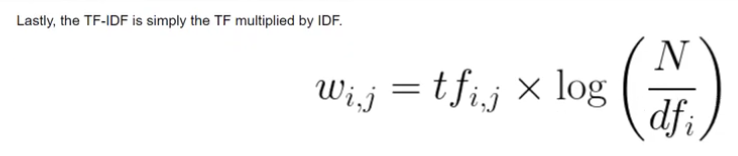

In [35]:
for_IDF = []
for i in range(0,len(my_anime_df['genre'])-1):
    num_of_words  = dict.fromkeys(all_unique, 0)
    for word in my_anime_df['genre'].values[i]:
        num_of_words[word] +=1
        tf = myTF(num_of_words, my_anime_df['genre'].values[i])   #считаем tf
    for_IDF.append(num_of_words) 
my_idfs = myIDF(for_IDF) #считаем idf


In [36]:
tfidf_df = pd.DataFrame()


In [37]:
for i in range(0,len(my_anime_df['genre'])-1): # считаем TFIDF
    num_of_words  = dict.fromkeys(all_unique, 0)
    for word in my_anime_df['genre'].values[i]:
        num_of_words[word] +=1
        tf1 = myTF(num_of_words, my_anime_df['genre'].values[i])  
    my_tfidf = myTFIDF(tf1, my_idfs)
    tfidf_df = tfidf_df.append([my_tfidf])
tfidf_df

,Y,j,P,G,-,V,A,a,K,i,...,m,t,C,w,e,D,r,v,F,y
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.064661,0.0,0.000000,...,0.027468,0.014890,0.000000,0.000000,0.014374,0.045628,0.048810,0.000000,0.000000,0.000000
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.035627,0.048313,0.0,0.019389,...,0.008551,0.037083,0.000000,0.000000,0.013425,0.028410,0.030391,0.029573,0.019264,0.019395
0,0.000000,0.0,0.041485,0.0,0.031618,0.000000,0.017484,0.031612,0.0,0.028544,...,0.016786,0.018198,0.016162,0.000000,0.008784,0.000000,0.029829,0.000000,0.018907,0.019036
0,0.000000,0.0,0.000000,0.0,0.113824,0.000000,0.000000,0.000000,0.0,0.051380,...,0.000000,0.000000,0.000000,0.000000,0.015811,0.000000,0.071589,0.000000,0.068065,0.000000
0,0.000000,0.0,0.062227,0.0,0.000000,0.000000,0.052451,0.000000,0.0,0.007136,...,0.000000,0.027297,0.000000,0.088988,0.032940,0.000000,0.044743,0.043538,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.176990,0.0,0.070006,0.0,0.000000,0.000000,0.000000,0.040009,0.0,0.016056,...,0.014163,0.015355,0.027274,0.000000,0.007412,0.000000,0.033557,0.000000,0.031906,0.048184
0,0.566368,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.051380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053691,0.000000,0.000000,0.000000
0,0.123123,0.0,0.000000,0.0,0.037116,0.101721,0.020524,0.037110,0.0,0.027924,...,0.009853,0.021363,0.000000,0.000000,0.010312,0.000000,0.070032,0.000000,0.022195,0.000000
0,0.314649,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.094836,0.0,0.014272,...,0.050358,0.000000,0.000000,0.000000,0.013176,0.083651,0.029829,0.000000,0.000000,0.000000


In [38]:
my_cosine_sim_genre = cosine_similarity(tfidf_df, tfidf_df)
my_cosine_sim_genre[:4, :4]

array([[1.        , 0.56889107, 0.53789793, 0.24037859],
       [0.56889107, 1.        , 0.59816798, 0.17711954],
       [0.53789793, 0.59816798, 1.        , 0.30588049],
       [0.24037859, 0.17711954, 0.30588049, 1.        ]])

## Первое значение - это сам фильм

In [39]:
%%time
give_recommendations('Naruto', my_cosine_sim_genre)

CPU times: user 65 ms, sys: 84.7 ms, total: 150 ms
Wall time: 39.6 ms


,Anime name,Similarity,Type,genre
0,Boruto: Naruto the Movie,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
1,Naruto: Shippuuden,1.000000,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
2,Naruto,1.000000,TV,"Action, Comedy, Martial Arts, Shounen, Super Power"
3,Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi,1.000000,Special,"Action, Comedy, Martial Arts, Shounen, Super Power"
4,Naruto x UT,1.000000,OVA,"Action, Comedy, Martial Arts, Shounen, Super Power"
5,Naruto: Shippuuden Movie 4 - The Lost Tower,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
6,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
7,Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!,1.000000,Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
8,Kyutai Panic Adventure!,0.980870,Special,"Action, Martial Arts, Shounen, Super Power"
9,Riki-Oh: Toukatsu Jigoku,0.962156,OVA,"Action, Martial Arts, Seinen, Super Power"


# Моя реал. для реком. на основании описания

In [40]:
all_unique_sypnopsis = set()
for i in range(0,len(my_anime_df['sypnopsis'])-1):
    unique_sypnopsis = set(my_anime_df['sypnopsis'].values[i]).union(set(my_anime_df['sypnopsis'].values[i+1]))
    all_unique_sypnopsis.update(unique_sypnopsis)



In [41]:
%%time
for_IDF_sypnopsis = []
for i in range(0,len(my_anime_df['sypnopsis'])-1):
    num_of_sypnopsis  = dict.fromkeys(all_unique_sypnopsis, 0)
    for sypn in my_anime_df['sypnopsis'].values[i]:
        num_of_sypnopsis[sypn] +=1
        tf = myTF(num_of_sypnopsis, my_anime_df['sypnopsis'].values[i])   #считаем tf
    for_IDF_sypnopsis.append(num_of_sypnopsis) 
my_idfs_sypnopsis = myIDF(for_IDF_sypnopsis) #считаем idf


CPU times: user 8min 30s, sys: 157 ms, total: 8min 30s
Wall time: 8min 31s


In [42]:
tfidf_df_sypnopsis = pd.DataFrame()

In [43]:
%%time
for i in range(0,len(my_anime_df['sypnopsis'])-1): # считаем TFIDF
    num_of_sypnopsis  = dict.fromkeys(all_unique_sypnopsis, 0)
    for sypn in my_anime_df['sypnopsis'].values[i]:
        num_of_sypnopsis[sypn] +=1
        tf_sypnopsis = myTF(num_of_words, my_anime_df['genre'].values[i])  
    my_tfidf_sypnopsis = myTFIDF(tf_sypnopsis, my_idfs_sypnopsis)
    tfidf_df_sypnopsis = tfidf_df_sypnopsis.append([my_tfidf_sypnopsis])
tfidf_df_sypnopsis

CPU times: user 1min 48s, sys: 37.6 ms, total: 1min 48s
Wall time: 1min 48s


,Y,j,P,G,-,V,A,a,K,i,...,m,t,C,w,e,D,r,v,F,y
0,0.054785,0.0,0.0,0.0,0.0,0.0,0.0,0.000239,0.0,0.000174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.034112,0.0,0.0,0.0,0.0,0.0,0.0,0.000149,0.0,0.000108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.033480,0.0,0.0,0.0,0.0,0.0,0.0,0.000146,0.0,0.000106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.120527,0.0,0.0,0.0,0.0,0.0,0.0,0.000526,0.0,0.000382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.050220,0.0,0.0,0.0,0.0,0.0,0.0,0.000219,0.0,0.000159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.056497,0.0,0.0,0.0,0.0,0.0,0.0,0.000247,0.0,0.000179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.180791,0.0,0.0,0.0,0.0,0.0,0.0,0.000789,0.0,0.000573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.039302,0.0,0.0,0.0,0.0,0.0,0.0,0.000171,0.0,0.000125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.100440,0.0,0.0,0.0,0.0,0.0,0.0,0.000438,0.0,0.000318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
my_cosine_sim_sypnopsis = cosine_similarity(tfidf_df_sypnopsis, tfidf_df_sypnopsis)
# my_cosine_sim_sypnopsis[:4, :4]

In [45]:
%%time
give_recommendations('Naruto', my_cosine_sim_sypnopsis)

CPU times: user 55.5 ms, sys: 39 ms, total: 94.5 ms
Wall time: 24.5 ms


,Anime name,Similarity,Type,genre
0,Gintama°,1.0,TV,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
1,Ginga Eiyuu Densetsu,1.0,OVA,"Drama, Military, Sci-Fi, Space"
2,Gintama,1.0,TV,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
3,Hajime no Ippo,1.0,TV,"Comedy, Drama, Shounen, Sports"
4,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,1.0,OVA,"Action, Drama, Historical, Martial Arts, Romance, Samurai"
5,Hajime no Ippo: New Challenger,1.0,TV,"Comedy, Drama, Shounen, Sports"
6,Gintama°: Aizome Kaori-hen,1.0,OVA,"Comedy, Parody"
7,Hajime no Ippo: Rising,1.0,TV,"Comedy, Drama, Shounen, Sports"
8,Yuri!!! on Ice,1.0,TV,"Comedy, Sports"
9,Gintama: Yorinuki Gintama-san on Theater 2D,1.0,Movie,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"


#### В целом, вот преимущества использования рекомендаций, основанных на содержании:
* Нет необходимости в данных о других пользователях, поэтому нет проблем с холодным запуском или разреженностью.
* Можно порекомендовать пользователям с уникальными вкусами.
* Можно порекомендовать новые и непопулярные фильмы.

#### Однако у этого подхода есть некоторые недостатки:
* Не рекомендуем элементы, не входящие в профиль содержимого пользователя.
* Невозможно использовать качественные суждения других пользователей.
* Этот метод всегда будет ограничен одним и тем же типом фильма, который пользователь видел в прошлом.

# 2 ЧАСТЬ Collaborative Filtering
### эту часть я делала в юпитер ноутбуке

# 3 ЧАСТЬ
# Deep Learning для коллаборативной фильтрации
* Нейронные сети - это, по сути, матричные операции.Методы матричной факторизации для рекомендательных систем тоже делают нечто подобное.
* Например: в SVD мы находим матрицы с использованием весов, рассчитанных SGD, что похоже на глубокое обучение.
* С небольшим отрывом, Deep Learning может превзойти SVD

In [46]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


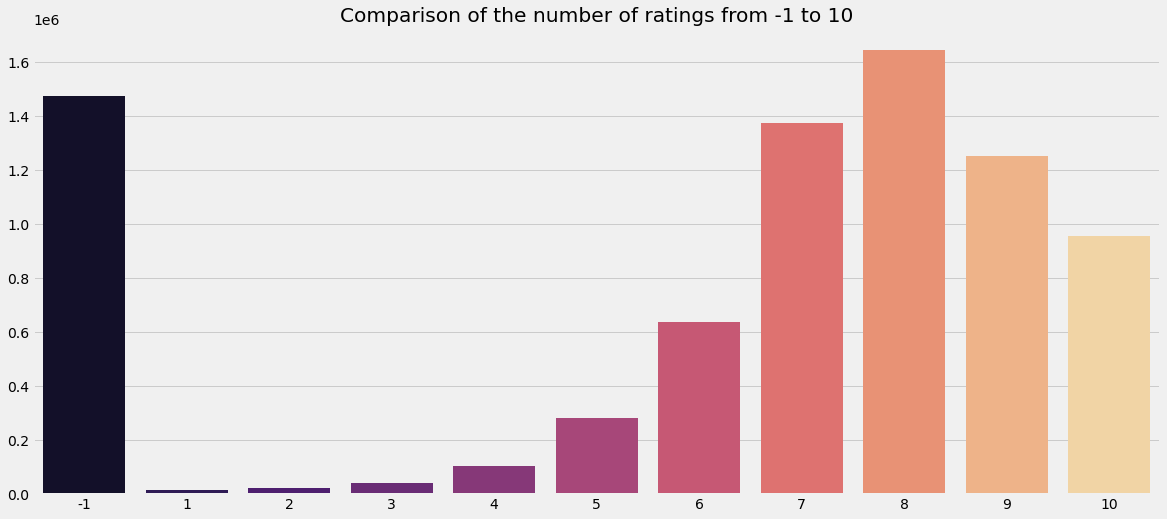

In [47]:
rating_count = rating['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from -1 to 10');

### В реальности многие пользователи не хотят выставлять оценку по какой-либо причине, может быть, потому что они ленивы. -1 означает, что пользователь смотрел аниме, но не присвоил рейтинг, поэтому удаляем это.

In [48]:

mask = (rating['rating'] == -1)
rating = rating.loc[~mask]
len(rating)

6337241

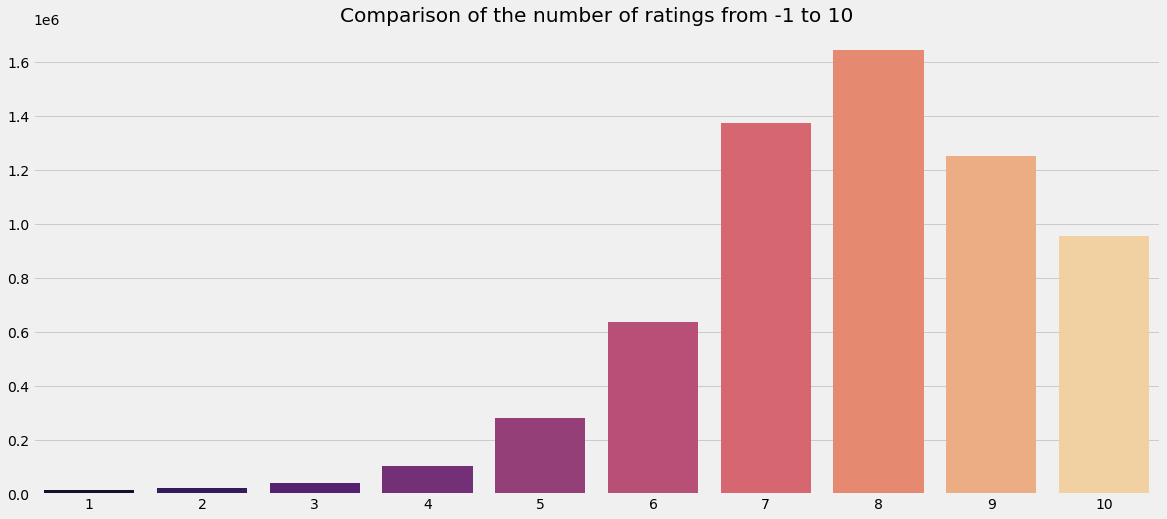

In [49]:
rating_count = rating['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from -1 to 10');

In [50]:
# rating = rating[rating['user_id'] < 10000] 

In [51]:
from sklearn.preprocessing import LabelEncoder #Encode target labels with value between 0 and n_classes-1.

user_enc = LabelEncoder()
rating['user_id'] = user_enc.fit_transform(rating['user_id'])


anime_enc = LabelEncoder()
rating['anime_id'] = anime_enc.fit_transform(rating['anime_id'])


In [52]:
userid_nunique = rating['user_id'].nunique()
anime_nunique = rating['anime_id'].nunique()

print('К-во уникальных id пользователей:', userid_nunique)
print('К-во уникальных id аниме', anime_nunique)

К-во уникальных id пользователей: 69600
К-во уникальных id аниме 9927


In [69]:
rating = rating[rating['user_id'] < 4000]

# Строим модель

In [70]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

print('Using tensorflow version:', tf.__version__)

Using tensorflow version: 2.4.1


In [71]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.1,
                                                  stratify=y,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((224894, 2), (24989, 2), (224894,), (24989,))

# 1 модель

In [72]:
def RecommenderV1(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Dot U and M
    x = Dot(axes=1)([U, M])
    
    model1 = Model(inputs=[user, movie], outputs=x)
    
    model1.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model1

In [73]:
model1 = RecommenderV1(userid_nunique, anime_nunique, 100)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 100)       6960000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       992700      input_6[0][0]                    
____________________________________________________________________________________________

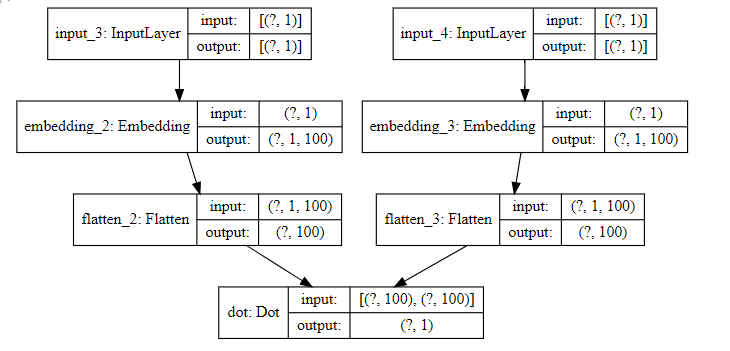

In [74]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [75]:
%%time
history1 = model1.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint1])

Epoch 1/20
3514/3514 [==============================] - 167s 47ms/step - loss: 64.2164 - val_loss: 64.0803
Epoch 2/20
3514/3514 [==============================] - 152s 43ms/step - loss: 63.5486 - val_loss: 59.5197
Epoch 3/20
3514/3514 [==============================] - 155s 44ms/step - loss: 55.8632 - val_loss: 42.5544
Epoch 4/20
3514/3514 [==============================] - 154s 44ms/step - loss: 37.3774 - val_loss: 24.1077
Epoch 5/20
3514/3514 [==============================] - 155s 44ms/step - loss: 20.7918 - val_loss: 14.5306
Epoch 6/20
3514/3514 [==============================] - 155s 44ms/step - loss: 12.8449 - val_loss: 9.9734
Epoch 7/20
3514/3514 [==============================] - 153s 44ms/step - loss: 8.7869 - val_loss: 7.3869
Epoch 8/20
3514/3514 [==============================] - 151s 43ms/step - loss: 6.5216 - val_loss: 5.8240
Epoch 9/20
3514/3514 [==============================] - 154s 44ms/step - loss: 5.0802 - val_loss: 4.8326
Epoch 10/20
3514/3514 [=====================

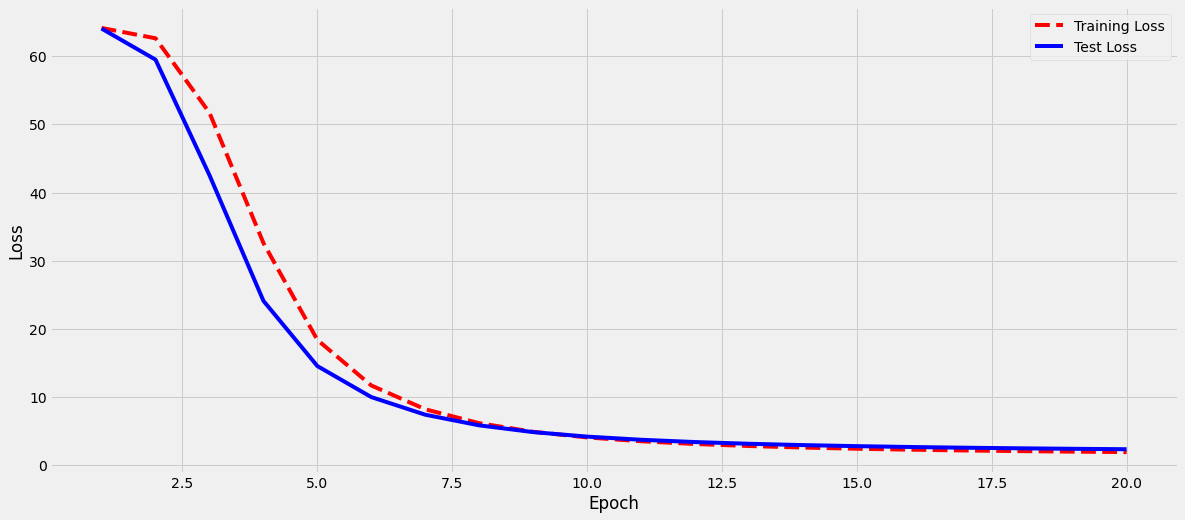

In [76]:
# Get training and test loss histories
training_loss1 = history1.history['loss']
test_loss1 = history1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss1) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss1, 'r--')
plt.plot(epoch_count, test_loss1, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [77]:
from keras.models import load_model
model1.save('my_model_new1.h5')

In [78]:
modelLoaded1 = tf.keras.models.load_model('my_model_new1.h5')

# 2 модель

In [79]:
def Recommender2(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Anime
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Gabungkan disini
    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dropout = Dropout(0.5)(dense_1)
    final = Dense(1)(dropout)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.001),
                  loss='mean_squared_error')
    
    return model


In [80]:
model2 = Recommender2(userid_nunique, anime_nunique, 100)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       6960000     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       992700      input_8[0][0]                    
____________________________________________________________________________________________

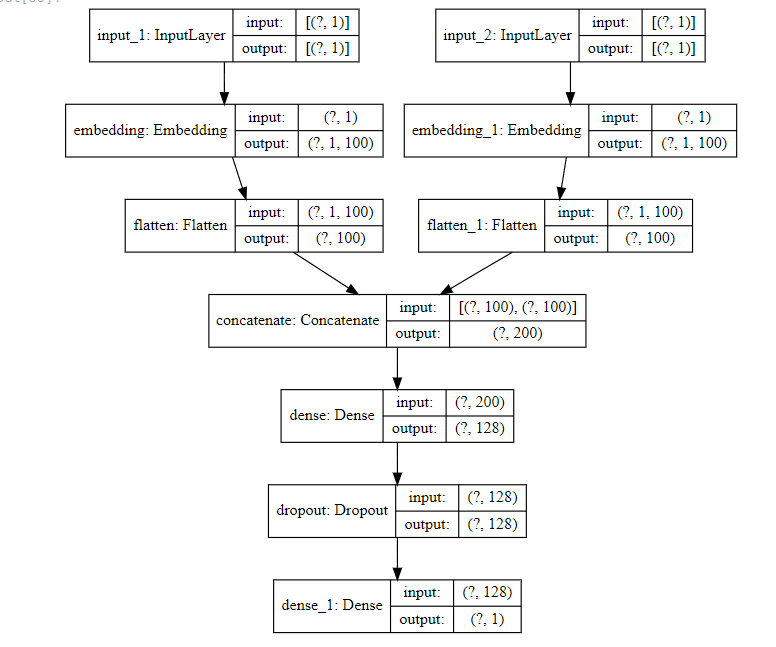

In [ ]:
# model = RecommenderV2(userid_nunique, anime_nunique, 100)

# SVG(model_to_dot(model2, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [81]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [82]:
%%time
history2 = model2.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint2])

Epoch 1/20
3514/3514 [==============================] - 159s 45ms/step - loss: 9.0829 - val_loss: 1.5386
Epoch 2/20
3514/3514 [==============================] - 159s 45ms/step - loss: 2.1504 - val_loss: 1.4471
Epoch 3/20
3514/3514 [==============================] - 158s 45ms/step - loss: 1.8833 - val_loss: 1.4154
Epoch 4/20
3514/3514 [==============================] - 160s 45ms/step - loss: 1.6464 - val_loss: 1.4168
Epoch 5/20
3514/3514 [==============================] - 158s 45ms/step - loss: 1.5139 - val_loss: 1.3907
Epoch 6/20
3514/3514 [==============================] - 163s 46ms/step - loss: 1.4013 - val_loss: 1.3731
Epoch 7/20
3514/3514 [==============================] - 165s 47ms/step - loss: 1.3328 - val_loss: 1.3684
Epoch 8/20
3514/3514 [==============================] - 157s 45ms/step - loss: 1.3015 - val_loss: 1.3634
Epoch 9/20
3514/3514 [==============================] - 158s 45ms/step - loss: 1.2441 - val_loss: 1.3591
Epoch 10/20
3514/3514 [==============================] 

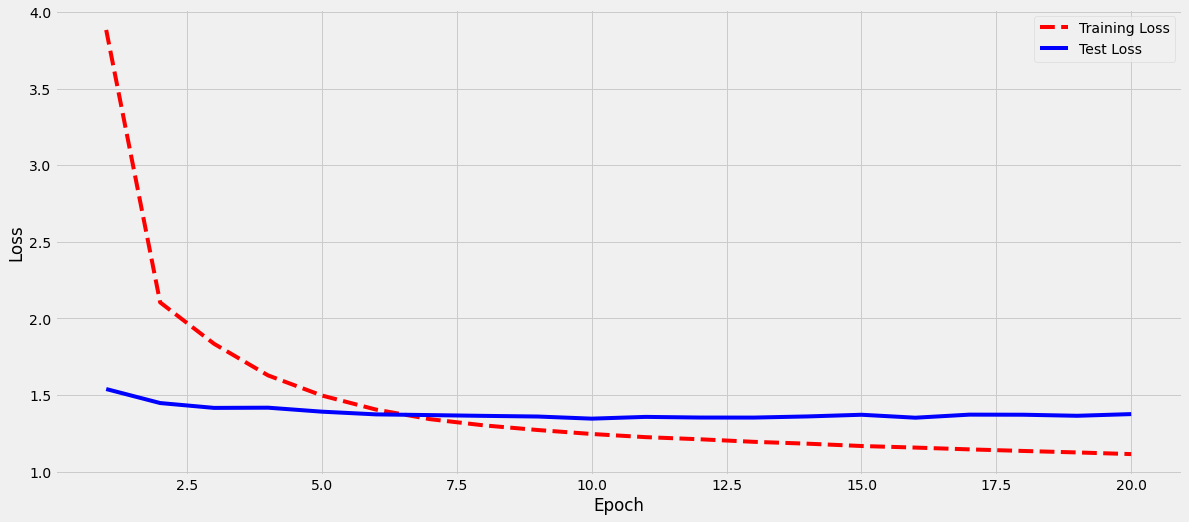

In [83]:
# Get training and test loss histories
training_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [84]:
from keras.models import load_model
model2.save('my_model_new2.h5')

In [85]:
modelLoaded2 = tf.keras.models.load_model('my_model_new2.h5')

## 3 модель

In [86]:

def Recommender3(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    U = Dense(64, activation='relu')(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    M = Dense(64, activation='relu')(M)
    
    # Dot U and M
    x = concatenate([U, M])
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    final = Dense(1)(x)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model

In [87]:
model3 = Recommender3(userid_nunique, anime_nunique, 100)
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 100)       6960000     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 100)       992700      input_10[0][0]                   
____________________________________________________________________________________________

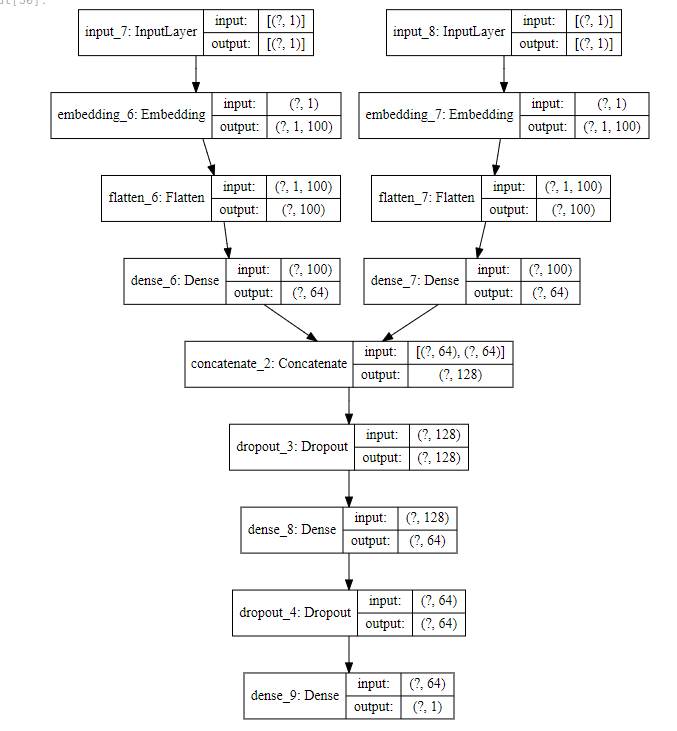

In [88]:
checkpoint3 = ModelCheckpoint('model3.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [89]:
%%time
history3 = model3.fit(x=[X_train['user_id'], X_train['anime_id']], y=y_train, batch_size=64, epochs=20,
                      verbose=1, validation_data=([X_val['user_id'], X_val['anime_id']], y_val), callbacks=[checkpoint3])

Epoch 1/20
3514/3514 [==============================] - 147s 42ms/step - loss: 21.7038 - val_loss: 1.5919
Epoch 2/20
3514/3514 [==============================] - 147s 42ms/step - loss: 3.4156 - val_loss: 1.5533
Epoch 3/20
3514/3514 [==============================] - 147s 42ms/step - loss: 3.2301 - val_loss: 1.4777
Epoch 4/20
3514/3514 [==============================] - 143s 41ms/step - loss: 3.0214 - val_loss: 1.4880
Epoch 5/20
3514/3514 [==============================] - 143s 41ms/step - loss: 2.8856 - val_loss: 1.4708
Epoch 6/20
3514/3514 [==============================] - 146s 41ms/step - loss: 2.7553 - val_loss: 1.4805
Epoch 7/20
3514/3514 [==============================] - 148s 42ms/step - loss: 2.6738 - val_loss: 1.4536
Epoch 8/20
3514/3514 [==============================] - 150s 43ms/step - loss: 2.5765 - val_loss: 1.4666
Epoch 9/20
3514/3514 [==============================] - 143s 41ms/step - loss: 2.4651 - val_loss: 1.4599
Epoch 10/20
3514/3514 [==============================]

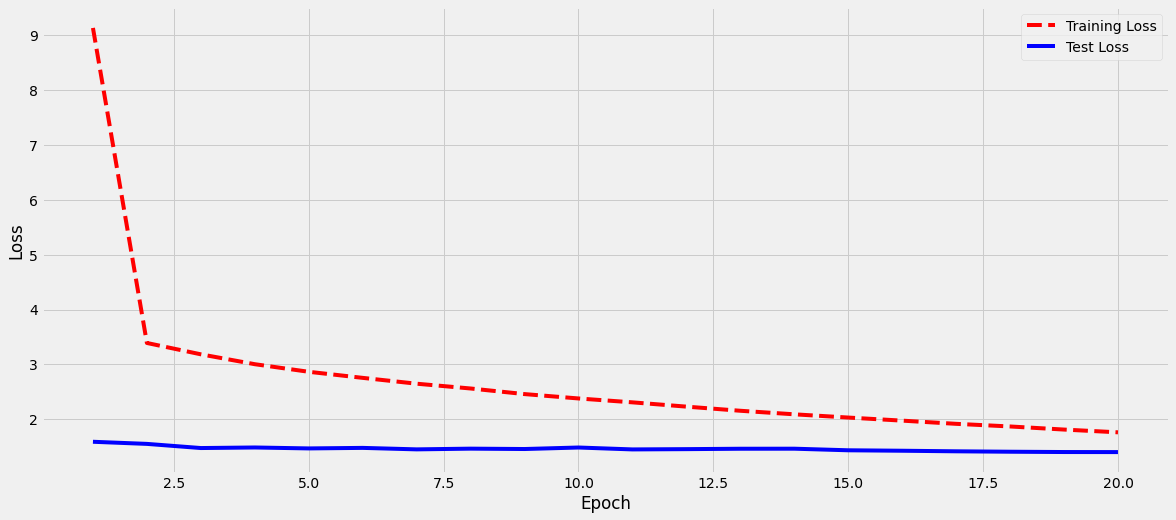

In [90]:
# Get training and test loss histories
training_loss3 = history3.history['loss']
test_loss3 = history3.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss3) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss3, 'r--')
plt.plot(epoch_count, test_loss3, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [91]:
model3.save('my_model_new3.h5')

In [92]:
modelLoaded3 = tf.keras.models.load_model('my_model_new3.h5')

In [93]:
def make_pred(user_id, anime_id, model):
    return model.predict([np.array([user_id]), np.array([anime_id])])[0][0]


In [94]:
def get_topN_rec(user_id, model):
    
    user_id = int(user_id) - 1
    user_ratings = rating[rating['user_id'] == user_id]
    recommendation = rating[~rating['anime_id'].isin(user_ratings['anime_id'])][['anime_id']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['anime_id'] , model), axis=1)
    recommendation.loc[:, 'rating_predict'] = recommendation['rating_predict']  -1 
    
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(anime_df[['anime_id', 'name', 'type', 'members']],
                                                                                       on='anime_id').head(10)
    
    return final_rec.sort_values('rating_predict', ascending=False)[['name', 'type', 'rating_predict']]

In [95]:
%%time
get_topN_rec(123, model1)

CPU times: user 4min 30s, sys: 4.64 s, total: 4min 35s
Wall time: 4min 30s


,name,type,rating_predict
0,Koi Hanabi,Music,9.734115
1,Astarotte no Omocha!,TV,9.461539
2,Daisetsusan no Yuusha Kibaou,Special,9.430843
3,Chicchana Yukitsukai Sugar,TV,9.358687
4,Meitantei Holmes,TV,9.300055
5,Anime Yasei no Sakebi,TV,9.272997
6,Genius Party,Movie,9.101401
7,Gift,OVA,9.079004
8,Tentai Senshi Sunred,TV,8.976166
9,Peut-etre Toi,Music,8.921926


In [96]:
%%time
get_topN_rec(123, model2)

CPU times: user 4min 26s, sys: 4.58 s, total: 4min 31s
Wall time: 4min 26s


,name,type,rating_predict
0,Panda Kopanda,Movie,9.466074
1,Angel Heart,TV,9.399113
2,Saint Beast: Kouin Jojishi Tenshi Tan,TV,9.373195
3,Higashi no Eden Movie II: Paradise Lost,Movie,9.369143
4,Shizuku,Movie,9.329659
5,"Shinran-sama: Negai, Soshite Hikari",OVA,9.303196
6,Koi Hanabi,Music,9.262265
7,Haou Taikei Ryuu Knight: Adeu Legend,OVA,9.234245
8,Animation!,OVA,9.225798
9,Koutetsu Tenshi Kurumi,TV,9.152184


In [97]:
%%time
get_topN_rec(123, model3)

CPU times: user 4min 23s, sys: 4.45 s, total: 4min 27s
Wall time: 4min 22s


,name,type,rating_predict
0,Koi Hanabi,Music,8.985758
1,Astarotte no Omocha!,TV,8.952458
2,Shizuku,Movie,8.910135
3,Daisetsusan no Yuusha Kibaou,Special,8.875635
4,Meitantei Holmes,TV,8.775093
5,Chicchana Yukitsukai Sugar,TV,8.774896
6,DT Eightron,TV,8.761578
7,Anime Yasei no Sakebi,TV,8.727266
8,Toki wo Kakeru Shoujo,Movie,8.703869
9,Mugen Senki Portriss,TV,8.680481
